# Customer activity: analysis report

### Data dictionary for online customer activity

- **administrative**: Columns which indicates which administrative activity the user was performing on their account.
- **administrative_duration**: How long a user performed administrative tasks in that session.
- **informational**: Indicates which informational activity the user was performing on the website.
- **informational_duration**: How long a users performed informational tasks in seconds during that session.
- **product_related**: Indicates which product the user was viewing on the website.
- **product_related_duration**: How long a user browsed products during that session. 
- **bounce_rates**: Historical bounce rate of that particular page for all users. They visited the directly and immediately exited. - This column has been dropped. Heavily correlated with 'exit_rates'.
- **exit_rates**: Historical exit rate of the users from that particular page. 
- **page_values**: The average value contribution of a page to a customer sale
- **month**: Month the users activity took place
- **operating_systems**: Operating system the user was using
- **browser**: The browser used by the user
- **region**: The region the user originated from
- **traffic_type**: How the user was redirected to the site
- **visitor_type**: Whether a customer was is new/returning or other
- **weekend**: Whether the activity only took place during the weekend
- **revenue**: Whether the customer purchased anything that session

In [1]:
from data_utils import DataTransform, DataFrameInfo, Plotter, StatisticalTests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customer_activity_df = pd.read_csv('preprocessed_data.csv')
customer_activity_skewed = pd.read_csv('preprocessed_skewed_data.csv')
customer_activity_df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
transformer = DataTransform(customer_activity_df)
customer_activity_df = transformer.convert_columns(['administrative','informational','product_related'],'int')
customer_activity_df = transformer.convert_columns(['month'],'date')

## Task 1: What are our customers doing?

### ***Are sales proportionally happening more on weekends?***

In [4]:
sales_weekends_df = customer_activity_df.iloc[:,-2:]
weekend_effect = sales_weekends_df.groupby(['weekend']).sum()
total_sales = sales_weekends_df['revenue'].sum()
print(total_sales)
weekend_effect['proportion_sales_percentage'] = (weekend_effect['revenue']/total_sales) * 100
weekend_effect.head()

1896


,revenue,proportion_sales_percentage
weekend,,
0,1465,77.267932
1,431,22.732068


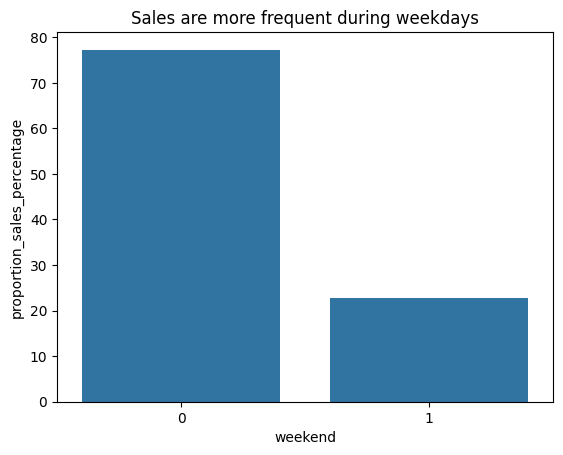

In [5]:
sns.barplot(x=weekend_effect.index, y=weekend_effect['proportion_sales_percentage'])
plt.title('Sales are more frequent during weekdays')
plt.show()

In [6]:
info_extractor = DataFrameInfo(customer_activity_df)
region_sales = info_extractor.get_slice(['region','revenue'])
region_sales = region_sales.groupby(['region'],as_index=False).sum()
region_sales

,region,revenue
0,Africa,130
1,Asia,187
2,Eastern Europe,194
3,North America,750
4,Northern Africa,82
5,Oceania,51
6,South America,130
7,Southern Africa,49
8,Western Europe,323


In [7]:
region_sales.at[4,'region'] = 'Africa'
region_sales.at[7,'region'] = 'Africa'
region_sales = region_sales.groupby(['region']).sum()
region_sales['proportion_sales_percentage'] = (region_sales['revenue']/total_sales) * 100
region_sales

,revenue,proportion_sales_percentage
region,,
Africa,261,13.765823
Asia,187,9.862869
Eastern Europe,194,10.232068
North America,750,39.556962
Oceania,51,2.689873
South America,130,6.856540
Western Europe,323,17.035865


/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_30457/742427083.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  rs = sns.barplot(x=region_sales.index, y=region_sales['proportion_sales_percentage'], order=order, palette='hls')
/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_30457/742427083.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rs.set_xticklabels(rs.get_xticklabels(), rotation=90)


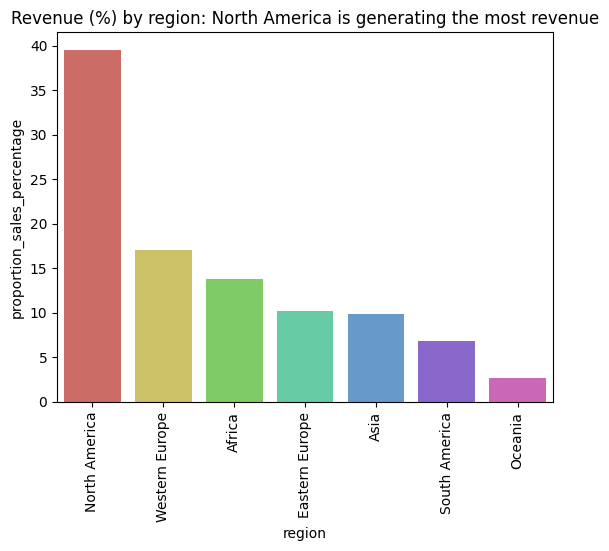

In [8]:
order = region_sales.sort_values(by='proportion_sales_percentage', ascending=False).index
rs = sns.barplot(x=region_sales.index, y=region_sales['proportion_sales_percentage'], order=order, palette='hls')
plt.title('Revenue (%) by region: North America is generating the most revenue')
rs.set_xticklabels(rs.get_xticklabels(), rotation=90)
plt.show()

### ***Is there any particular website traffic that stands out when generating sales?***

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_30457/2208992666.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  wt.set_xticklabels(wt.get_xticklabels(), rotation=90)


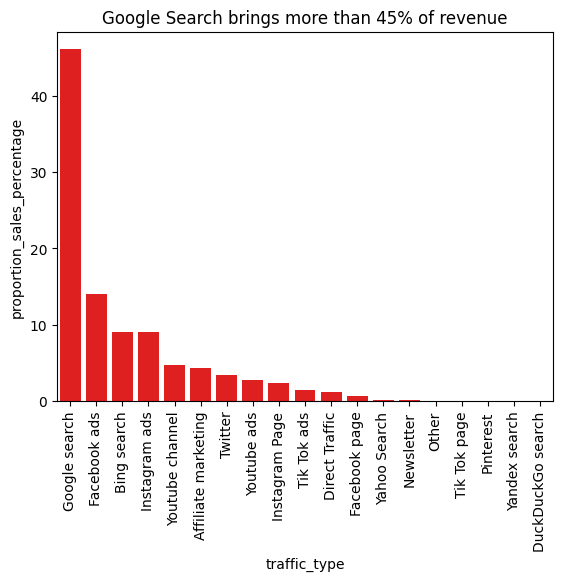

In [9]:
website_traffic = info_extractor.get_slice(['traffic_type','revenue'])
website_traffic = website_traffic.groupby(['traffic_type']).sum()
website_traffic['proportion_sales_percentage'] = (website_traffic['revenue']/total_sales) * 100
order_w = website_traffic.sort_values(by='proportion_sales_percentage', ascending=False).index
wt = sns.barplot(x=website_traffic.index, y=website_traffic['proportion_sales_percentage'], order =order_w, color='r')
plt.title('Google Search brings more than 45% of revenue')
wt.set_xticklabels(wt.get_xticklabels(), rotation=90)
plt.show()

### ***What percentage of time is spent on the website performing administrative/product or informational related tasks?***

In [10]:
info_extractor_2 = DataFrameInfo(customer_activity_skewed)
admin_task = info_extractor_2.get_slice(['administrative','administrative_duration'])
product_related_task = info_extractor_2.get_slice(['product_related','product_related_duration'])
informational_task = info_extractor_2.get_slice(['informational','informational_duration'])
combined = info_extractor_2.get_slice(['administrative_duration','informational_duration','product_related_duration'])

In [11]:
# For our purpose, we are going to drop all records where time = 0 for all three task types simultaneously 
combined_filtered = combined[~((combined['administrative_duration'] == 0) & (combined['informational_duration'] == 0) & (combined['product_related_duration'] == 0))]

In [12]:
task_times = combined_filtered.copy()
task_times['total_time_per_visit'] = task_times['administrative_duration'] + task_times['informational_duration'] + task_times['product_related_duration']
task_times['admin_time_%'] = (task_times['administrative_duration'] / task_times['total_time_per_visit']) * 100
task_times['info_time_%'] = (task_times['informational_duration'] / task_times['total_time_per_visit']) * 100
task_times['product_time_%'] = (task_times['product_related_duration'] / task_times['total_time_per_visit']) * 100


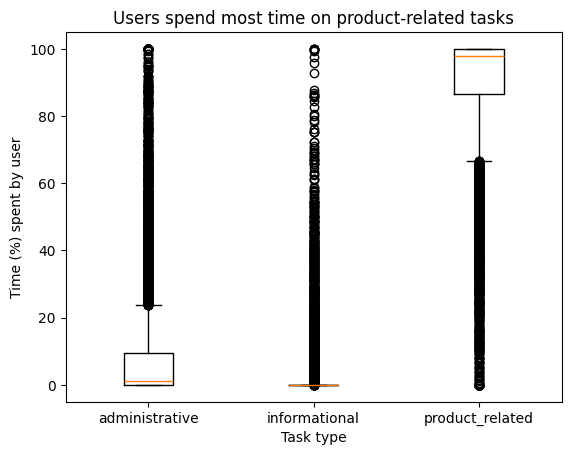

In [13]:
labels=['administrative', 'informational', 'product_related']
plt.boxplot([task_times['admin_time_%'], task_times['info_time_%'], task_times['product_time_%']], labels=labels )
plt.xlabel('Task type')
plt.ylabel('Time (%) spent by user')
plt.title('Users spend most time on product-related tasks')
plt.show()

### ***Are there any informational/administrative tasks which users spend time doing most?***

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_30457/3622874086.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  at.set_xticklabels(at.get_xticklabels(), rotation=90)


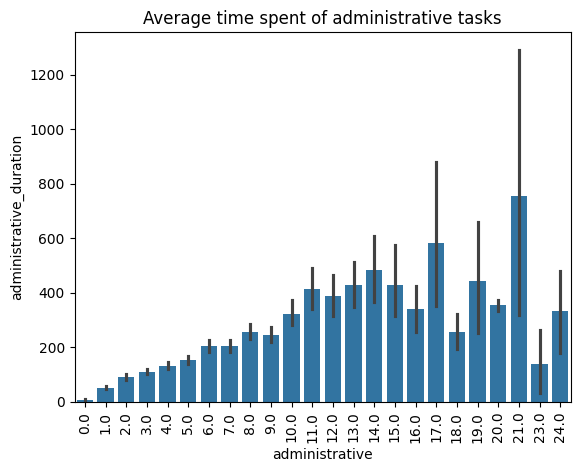

In [14]:
at = sns.barplot(data=admin_task, y="administrative_duration", x="administrative")
plt.title('Average time spent of administrative tasks')
at.set_xticklabels(at.get_xticklabels(), rotation=90)
plt.show()

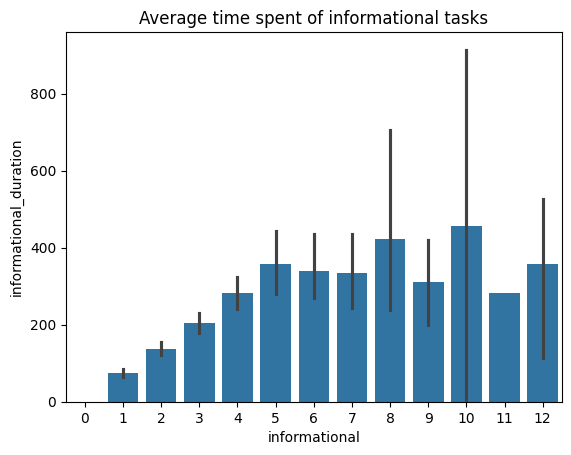

In [15]:
sns.barplot(data=informational_task, y="informational_duration", x="informational")
plt.title('Average time spent of informational tasks')
plt.show()

### ***What is the breakdown of months making the most sales?***

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_30457/3553238107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_sales['month'] = month_sales['month'].dt.month


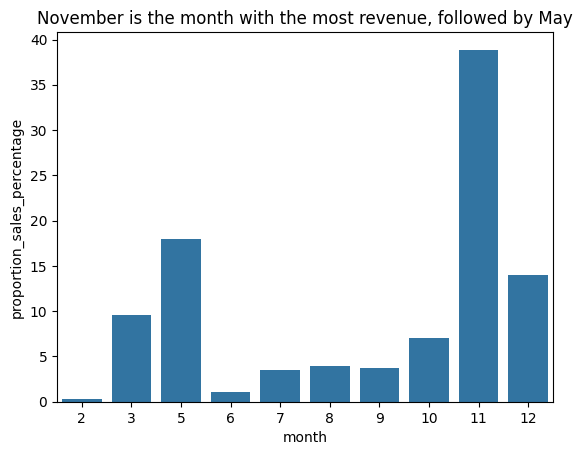

In [16]:
month_sales = info_extractor.get_slice(['month','revenue'])
month_sales['month'] = month_sales['month'].dt.month
month_sales = month_sales.groupby(['month']).sum()
month_sales['proportion_sales_percentage'] = (month_sales['revenue']/total_sales) * 100
sns.barplot(x=month_sales.index, y=month_sales['proportion_sales_percentage'])
plt.title('November is the month with the most revenue, followed by May')
plt.show()


## Task 2: What ***software*** are our customers using the most to access the website?

### ***The count of the operating systems used to visit the site and the percentage of the total***

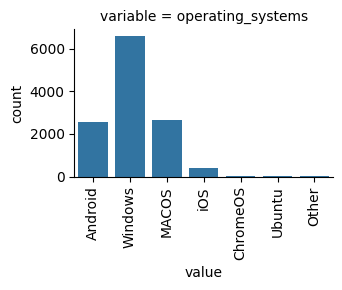

In [17]:
plotter = Plotter(customer_activity_df)
plotter.count_plots_grid(['operating_systems'])

In [18]:
total_entries = len(customer_activity_df['operating_systems'])
os_counts = customer_activity_df.copy()
info_extractor_3 = DataFrameInfo(os_counts)
os_counts = info_extractor_3.get_slice(["operating_systems"])
os_counts['counts'] = 1
os_counts = os_counts.groupby(['operating_systems']).sum()
os_counts["count_%"] = (os_counts['counts'] / total_entries) * 100
os_counts

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_30457/1370675072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_counts['counts'] = 1


,counts,count_%
operating_systems,,
Android,2579,21.056499
ChromeOS,25,0.204115
MACOS,2671,21.807642
Other,7,0.057152
Ubuntu,9,0.073481
Windows,6572,53.657740
iOS,385,3.143370


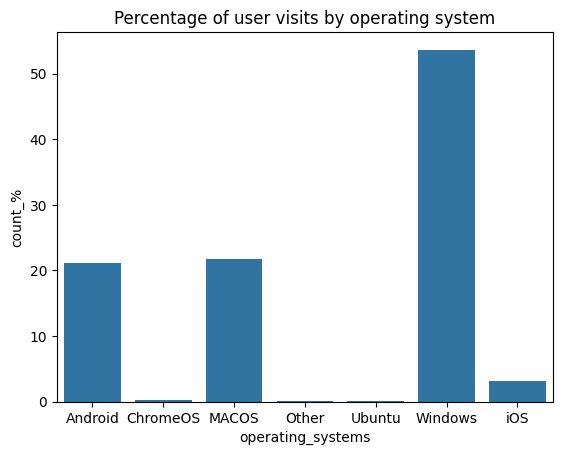

In [19]:
sns.barplot(x=os_counts.index, y=os_counts['count_%'])
plt.title('Percentage of user visits by operating system')
plt.show()

### ***The amount of users visiting the site using mobile operating system and desktop operating systems***

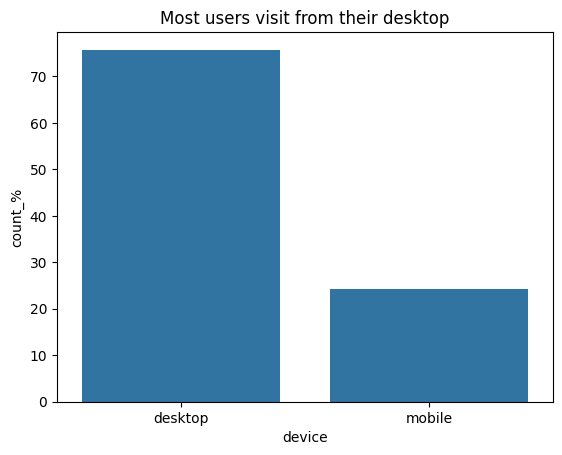

In [20]:
# Add column for device type (mobile or desktop) and drop outliers in operating systems ('Other')
map_dev = {'Android':'mobile', 'iOS':'mobile', 'MACOS': 'desktop','ChromeOS':'desktop','Windows':'desktop','Ubuntu':'desktop'}
device_df = os_counts.copy()
device_df['device'] = device_df.index.map(map_dev)
device_df.dropna(subset='device', inplace=True)
device_df_grouped = device_df.groupby(['device']).sum().reset_index()
sns.barplot(x=device_df_grouped['device'], y=device_df_grouped['count_%'])
plt.title('Most users visit from their desktop')
plt.show()

### ***The most commonly used browsers and their breakdown on mobile versus desktop***

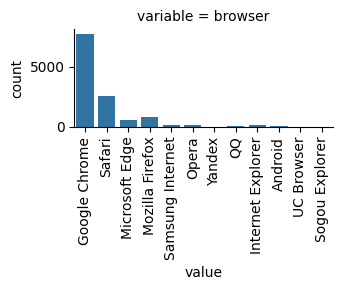

In [21]:
plotter.count_plots_grid(['browser'])
#sns.catplot(x='class', y='survival rate', hue='sex', data=dfm, kind='bar', height=5, aspect=1)

In [22]:
browser_device_region = customer_activity_df.copy()
browser_device_region['device'] = browser_device_region['operating_systems'].map(map_dev)
browser_device_region.dropna(subset='device', inplace=True)
browser_device_region['counts'] = 1
info_extractor = DataFrameInfo(browser_device_region)
browser_device_region =  info_extractor.get_slice(['operating_systems','browser','region','device','counts'])
browser_device_region = browser_device_region[browser_device_region['browser'] != 'Yandex']
browser_device_region = browser_device_region[browser_device_region['browser'] != 'UC Browser']
browser_device_region = browser_device_region[browser_device_region['browser'] != 'Sogou Explorer']

In [23]:
browser_device = browser_device_region.groupby(['browser','device']).sum(['counts'])
browser_device['counts_%'] = (browser_device['counts']/total_entries)*100

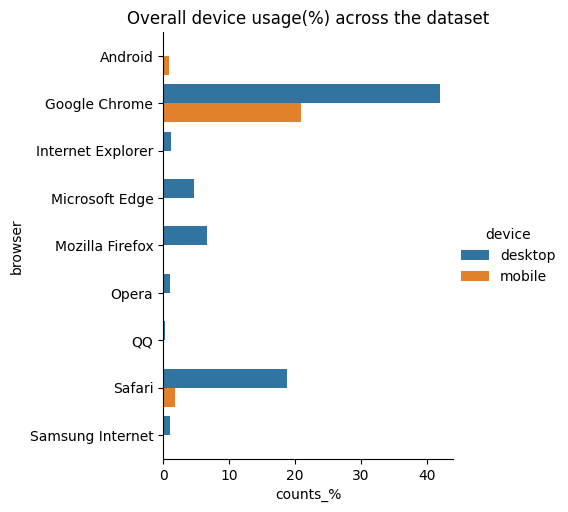

In [24]:
sns.catplot(y='browser', x='counts_%', hue='device', data=browser_device, kind='bar', height=5, aspect=1)
plt.title('Overall device usage(%) across the dataset')
plt.show()

In [25]:
browser_dev_df2 = browser_device_region.groupby(['browser']).sum(['counts'])
browser_dev_df2.rename(columns={"counts":"counts_per_browser"},inplace=True)
browser_device = browser_device.join(browser_dev_df2)
browser_device["counts_%_relative"] = (browser_device["counts"] / browser_device['counts_per_browser']) * 100

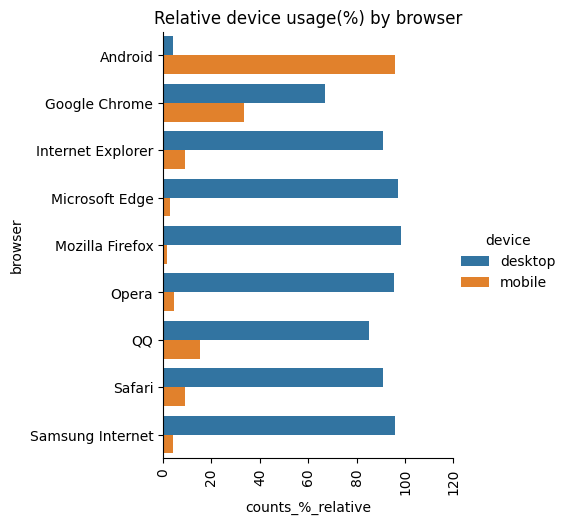

In [26]:
g = sns.catplot(y='browser', x='counts_%_relative', hue='device', data=browser_device, kind='bar', height=5, aspect=1)
g.set_xticklabels(rotation=90)
plt.title('Relative device usage(%) by browser')
plt.show()

### Based on this analysis of what are the most popular operating systems, ***are there any regions where there is a discrepancy in what is popular?*** 

This could be an indication that users in that region are having technical issues that the tech team might want to investigate.

In [27]:
os_region = browser_device_region.copy()
map_reg = {'Africa':'Africa','Northern Africa':'Africa','Southern Africa':'Africa', 'Oceania': 'Oceania', 'Eastern Europe': 'Eastern Europe','Western Europe': 'Western Europe','Asia':'Asia','North America':'North America', 'South America':'South America'}
os_region['region'] = os_region['region'].map(map_reg)
os_region_df1 = os_region.groupby(['region', 'operating_systems']).sum(['counts'])
os_region_df1['counts_%'] = (os_region_df1['counts']/total_entries)*100                                                                    

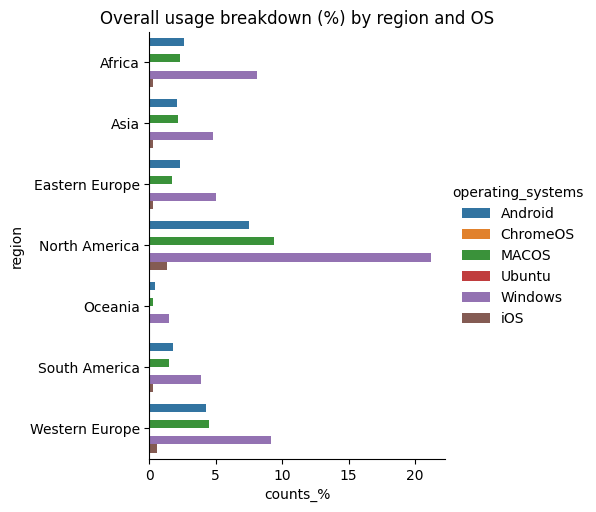

In [28]:
sns.catplot(y='region', x='counts_%', hue='operating_systems', data=os_region_df1, kind='bar')
plt.title('Overall usage breakdown (%) by region and OS')
plt.show()

In [29]:
os_region_df2 = os_region.groupby(['region']).sum(['counts'])
os_region_df2.rename(columns={"counts":"counts_per_region"},inplace=True)
os_region_df2 = os_region_df1.join(os_region_df2)
os_region_df2["counts_%_relative"] = (os_region_df2["counts"] / os_region_df2['counts_per_region']) * 100

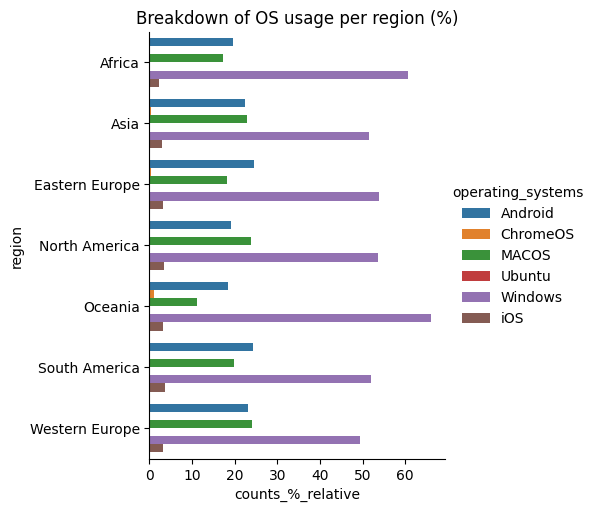

In [30]:
sns.catplot(y='region', x='counts_%_relative', hue='operating_systems', data=os_region_df2, kind='bar')
plt.title('Breakdown of OS usage per region (%)')
plt.show()

## Task 3: Do we need to optimise our marketing strategy?

### ***What traffic is currently generating the most revenue, broken down by region?***

In [31]:
df1 = customer_activity_df.copy()
info_extractor_4 = DataFrameInfo(df1)
df1 = info_extractor_4.get_slice(['traffic_type','region','revenue'])
df1['region'] = df1['region'].map(map_reg)
df1 = df1[df1['traffic_type'] != 'Yandex search']
df1 = df1[df1['traffic_type'] != 'DuckDuckGo search']
df1 = df1[df1['traffic_type'] != 'Other']
df1 = df1[df1['traffic_type'] != 'Tik Tok page']
df1 = df1[df1['traffic_type'] != 'Pinterest']
df2 = df1.groupby(['traffic_type','region']).sum() 
total_revenue = df2['revenue'].sum()
df2['%_total_revenue'] = (df2['revenue']/total_revenue)*100           

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_30457/1834484395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['region'] = df1['region'].map(map_reg)


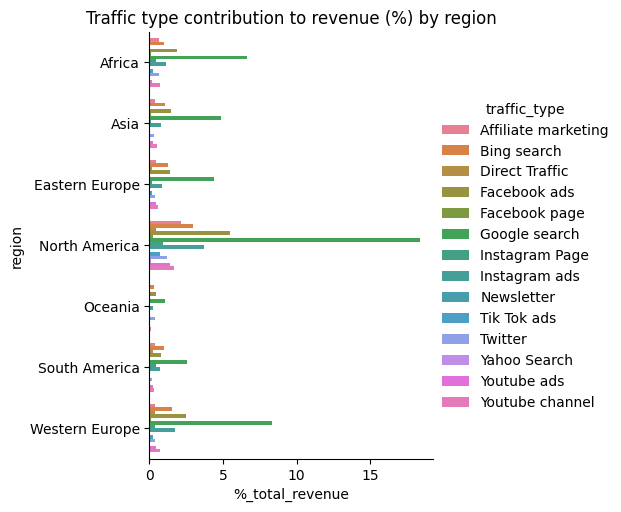

In [32]:
sns.catplot(y='region', x='%_total_revenue', hue='traffic_type', data=df2, kind='bar')
plt.title('Traffic type contribution to revenue (%) by region')
plt.show()

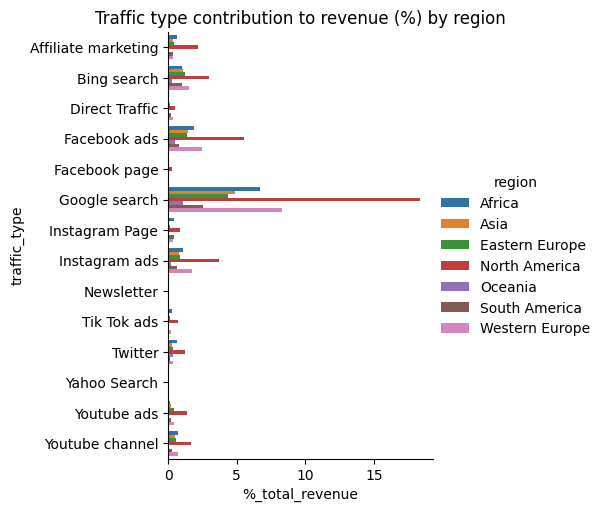

In [33]:
sns.catplot(y='traffic_type', x='%_total_revenue', hue='region', data=df2, kind='bar')
plt.title('Traffic type contribution to revenue (%) by region')
plt.show()

In [34]:
df3 = df1.groupby(['region']).sum()
df3.rename(columns={"revenue":"revenue_by_region"},inplace=True)
del df3['traffic_type']
df4 = df1.groupby(['region','traffic_type']).sum() 
df3 = df4.join(df3)
df3["revenues_%_relative"] = (df3["revenue"] / df3['revenue_by_region']) * 100

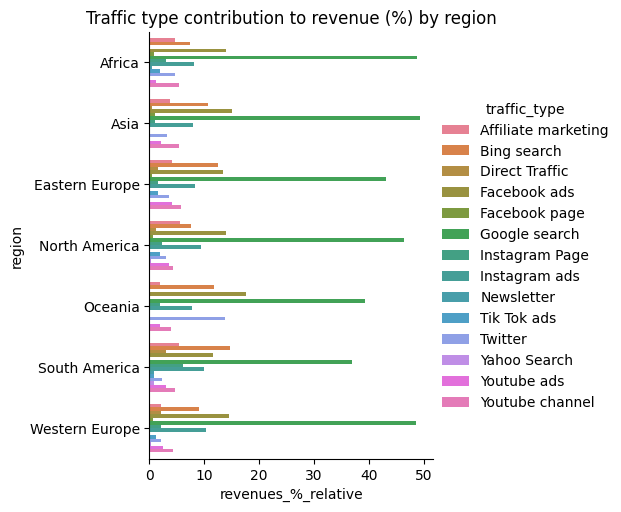

In [35]:
sns.catplot(y='region', x='revenues_%_relative', hue='traffic_type', data=df3, kind='bar')
plt.title('Traffic type contribution to revenue (%) by region')
plt.show()

In [37]:
df5 = df1.groupby(['traffic_type']).sum()
df5.rename(columns={"revenue":"revenue_by_traffic_type"},inplace=True)
del df5['region']
df5 = df2.join(df5)
df5["revenues_%_relative"] = (df5["revenue"] / df5['revenue_by_traffic_type']) * 100

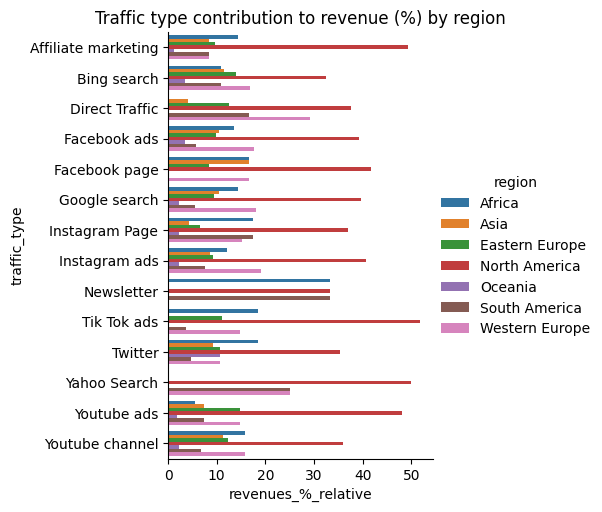

In [38]:
sns.catplot(y='traffic_type', x='revenues_%_relative', hue='region', data=df5, kind='bar')
plt.title('Traffic type contribution to revenue (%) by region')
plt.show()

### ***What traffic has the highest bounce rate?***

This could indicate that the marketing channels advertisement isn't enticing enough - for the customers. Conversely a low bounce rate can indicate that the strategy is highly effective. Break down this data by region.

### ***What months have generated the most sales from ads traffic?***

## Task 4